# Removing outliers in streaming conformal outlier detection

To test for outliers with streaming conformal at time $t$, we test for exchangeability on of $((X_1, Y_1), \dots, (X_t, Y_t))$

However, if there are other outliers at $s < t$ we may reject when test-point $t$ is not an outlier, but nonetheless exchangeability is violated. Put simply, we are relying on the fact that the $t-1$ training observations are all inliers.

What happens if we just exclude the observations that were considered outliers?

In [133]:
def score(X, y, mu):
    """
    X: n x p features
    y: n responses
    mu: function mu(x_i) = E[Y| X = x_i]
    """
    return np.abs(mu(X) - y)

def compute_conformal_p(s):
    """
    given a vector of scores s, compute the conformal p value for the last score
    
    the conformal p-value is the proprotion of scores smaller than the test point
    so if the test point score is large, the conformal p-value is small
    """
    return np.sum(s >= s[-1])/s.size


def linear_scoring_coef(X, y):
    """
    generate sequences (a1,..., an), (b1, ... ,bn)
    so that r_i(y) = |a_i + b_i y|
    
    we can use this to compute full conformal predictions sets for least squares
    """
    X = np.random.normal(size=(100, 10))
    y = np.random.normal(size=100)

    H = X @ np.linalg.solve(X.T @ X, X.T)
    A = np.eye(H.shape[0]) - H
    y0 = y
    y0[-1] = 0

    a = A @ y0
    b = A[:,-1]
    
    return dict(a=a, b=b)

def grid_conformal_p(X, y, y_grid):
    """
    compute conformal p-values for a grid of $y_n$ values
    """
    coefs = linear_scoring_coef(X, y)
    p_values = np.array([
        compute_conformal_p(np.abs(coefs['a'] + coefs['b'] * z))
        for z in  y_grid
    ])
    return p_values


grid_conformal_p(X, y, [-3, -2, -1, 0, 1, 2, 3, 4,])

array([0.01, 0.11, 0.36, 0.89, 0.41, 0.11, 0.04, 0.01])

A quick simulation can verify that for exchangeable data, the streaming $p$-values are unifrom and independent (we observe low autocorrelation among $p$-values.

array([[1.        , 0.00139461],
       [0.00139461, 1.        ]])

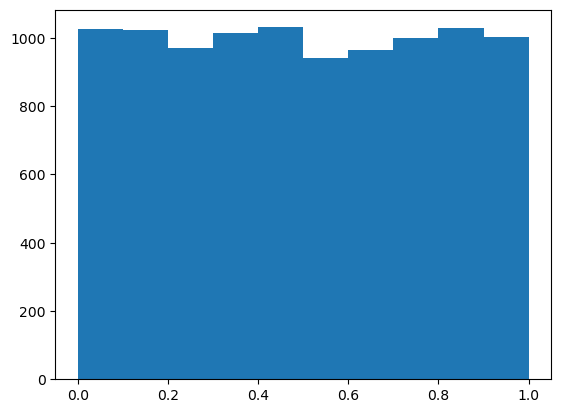

In [142]:
t = 10000
X = np.random.uniform(size=t)
y = np.sin(X) + np.random.normal(size=t)


mu_oracle = lambda x: np.sin(x)

scores = score(X, y, mu_oracle)
stream_p = np.array([compute_conformal_p(scores[:i]) for i in np.arange(1, t)])
plt.hist(stream_p)
np.corrcoef(stream_p[:-1], stream_p[1:])

Now let's see what happens if we exclude samples that are detected as outliers. What we expect to see is that

In [139]:
a = [1]
a.append(2)
a

[1, 2]

In [149]:
def masked_conformal_p(s, mask):
    """
    compute conformal p-value for s[mask]
    mask is a vector of booleans for which observations are included
    """
    return compute_conformal_p(s, mask)

def threshold_conformal_p(s, alpha=0.05):
    T = s.size
    mask = np.array([False for _ in range(T)])
    mask[0] = True
    p = []
    for t in range(1, T):
        # include this observation in this run
        mask[t] = True
        
        # compute a masked conformal p-value
        p_t = compute_conformal_p(s[mask])
        p.append(p_t)
        
        # for future runs, mark if t was an outlier
        mask[t] = p_t >= alpha
        
    return dict(p=p, mask=mask)

t = 10000
X = np.random.uniform(size=t)
y = np.sin(X) + np.random.normal(size=t)

mu_oracle = lambda x: np.sin(x)

scores = score(X, y, mu_oracle)
res = threshold_conformal_p(scores)

Dropping outliers does not work because you will also drop "unusual" observations from the null distribution. Over time this will have the effect of truncating the tails of the null distribution. Run for long enough we will also cut of the tails of the truncated distribution, and so on until we reject almost all observations.


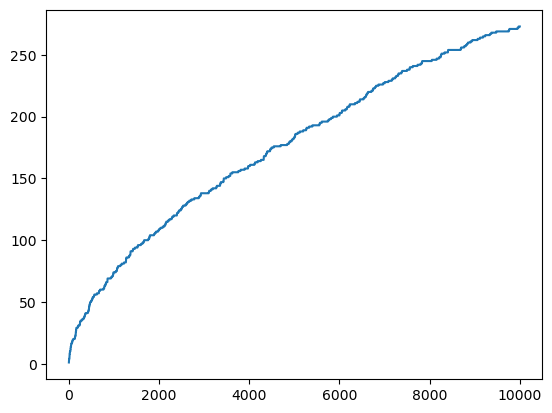

In [175]:
# as we go along our data stream we start to reject at increasingly higher rate
# but all the data are exchangeable.

t = 10000
X = np.random.uniform(size=t)
y = np.sin(X) + np.random.normal(size=t)
scores = score(X, y, mu_oracle)

res = threshold_conformal_p(scores, 0.5)
plt.plot(np.cumsum(res['mask']))

(array([9021.,  383.,  173.,   91.,   63.,   57.,   47.,   52.,   53.,
          59.]),
 array([0.00364964, 0.10328467, 0.20291971, 0.30255474, 0.40218978,
        0.50182482, 0.60145985, 0.70109489, 0.80072993, 0.90036496,
        1.        ]),
 <BarContainer object of 10 artists>)

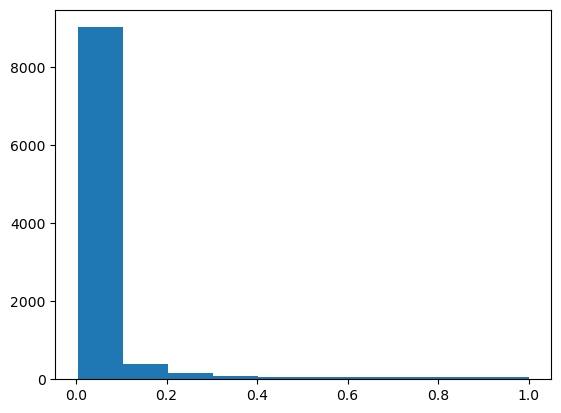

In [176]:
plt.hist(res['p'])

(array([5273., 1312.,  742.,  641.,  483.,  390.,  336.,  288.,  251.,
         284.]),
 array([4.69704086e-04, 1.00422734e-01, 2.00375763e-01, 3.00328793e-01,
        4.00281822e-01, 5.00234852e-01, 6.00187882e-01, 7.00140911e-01,
        8.00093941e-01, 9.00046970e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

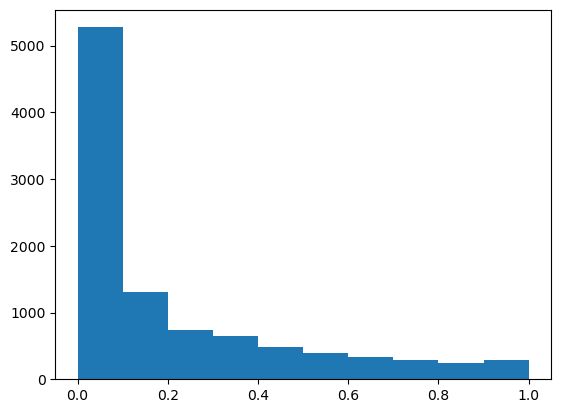

In [223]:
def randomized_conformal_p(s, alpha=0.05):
    """
    at each step t , include the observation i = 1... t-1
    with probability p_i where p_i is the conformal p-value
    """
    T = s.size
    p = np.ones(T)
    for t in range(1, T):
        # random mask
        mask = p[:t] >= np.random.uniform(size=t)
        mask[t-1] = True

        # compute a masked conformal p-value
        p[t-1] = compute_conformal_p(s[:t][mask])
    return p

res = randomized_conformal_p(scores, 0.5)
plt.hist(res)

The appropriate rate at which to reject observations would be the local true discovery rate. This takes into account the proportion of outlier observations in the data stream, and the change in distribution of the outlier samples. Both of these quantities are typically unavailable in practice. But first let's see what happens with the oracle case.

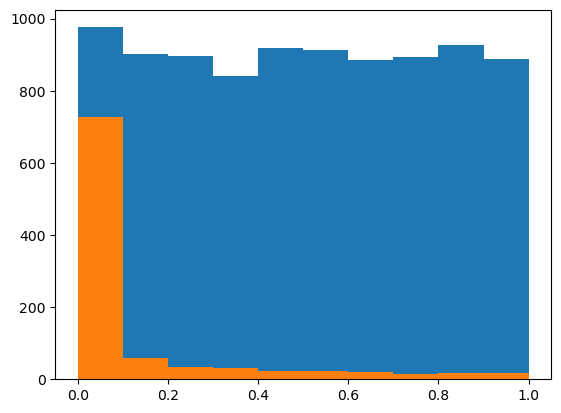

In [262]:
def compute_tdr(x, y):
    f0 = norm.pdf(y-np.sin(x), scale=1)
    f1 = norm.pdf(y-np.sin(x), scale=5)
    tdr = pi*f1/(pi*f1 + (1-pi)*f0)
    return tdr


def tdr_randomized_conformal_p(s, tdr, alpha=0.05):
    """
    at each step t , include the observation i = 1... t-1
    with probability p_i where p_i is the conformal p-value
    """
    T = s.size
    p = np.ones(T)
    for t in range(1, T):
        # random mask
        mask = tdr[:t] < np.random.uniform(size=t)
        mask[t-1] = True

        # compute a masked conformal p-value
        p[t-1] = compute_conformal_p(s[:t][mask])
    return p

t = 10000
pi = 0.1

X = np.random.uniform(size=t)
z = np.random.binomial(1, pi, size=t)

y = np.sin(X) + np.random.normal(size=t)*(1-z) + 5*np.random.normal(size=t)*z
scores = score(X, y, mu_oracle)
tdr = compute_tdr(X, y)

res = tdr_randomized_conformal_p(scores, tdr)
plt.hist(res[z==0]);
plt.hist(res[z==1]);

Estimating $tdr$ is hard. Perhaps and easier quantity to estimate is FDR among the set of rejections. For a given threshold $\alpha$ we can as what the proprotion of false discoveries (inliers detected as outliers), and then include a random fraction of these discoveries in future computations.

(array([65.,  4.,  3.,  5.,  5.,  0.,  1.,  4.,  6.,  7.]),
 array([0.        , 0.08179817, 0.16359633, 0.2453945 , 0.32719266,
        0.40899083, 0.490789  , 0.57258716, 0.65438533, 0.73618349,
        0.81798166]),
 <BarContainer object of 10 artists>)

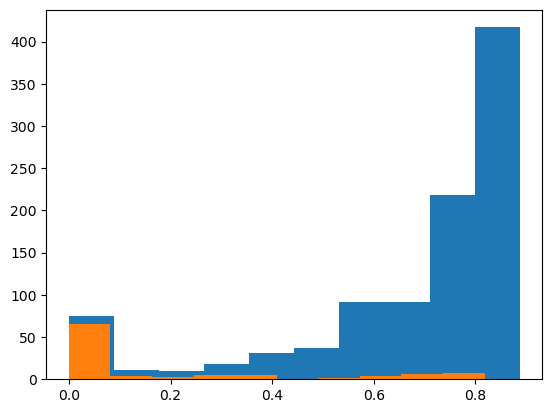

In [328]:
def qvalue(pvals, lamb=0.5):
    """
    Simplified computation of p-value, estimate pi0_hat from the right tail of p-values
    """
    m = pvals.size
    pi0_hat = np.sum(pvals > lamb)/ (m * (1-lamb))
    sort_idx = np.argsort(pvals)

    qvals = np.zeros(m)
    qvals[sort_idx[-1]] = pi0_hat * pvals[sort_idx[-1]]
    qvals[sort_idx[-1]]

    for i in range(2, m):
        qvals[sort_idx[-i]] = min(qvals[sort_idx[-(i-1)]], pi0_hat*m*pvals[sort_idx[-i]]/(m-i))
    return qvals  
    
lamb = 0.5
pvals = np.random.uniform(size=1000)
pvals[:100] = np.random.beta(0.1, 2, size=100)

qvalue(pvals, 0.5)
plt.hist(qvals)
plt.hist(qvals[:100])

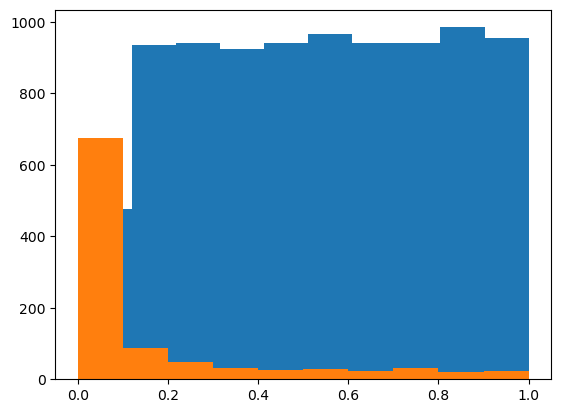

In [349]:
def FDR_randomized_conformal_p(s, alpha=0.05):
    """
    at each step t , include the observation i = 1... t-1
    with probability p_i where p_i is the conformal p-value
    """
    T = s.size
    p = np.ones(T)
    for t in range(1, T):
        # compute q values for old p-values
        if(t > 5):
            qvals = qvalue(p[:t-1])
            reject_set = qvals < alpha
            
            # include rejections w/probability alpha
            mask = np.ones(t)
            mask[np.where(reject_set)[0]] = np.random.binomial(1, alpha, size=reject_set.sum())
            mask = mask == 1

            # compute a masked conformal p-value
            p[t-1] = compute_conformal_p(s[:t][mask])
        else:
            p[t-1] = compute_conformal_p(s[:t])
    return p

t = 10000
pi = 0.1

X = np.random.uniform(size=t)
z = np.random.binomial(1, pi, size=t)

y = np.sin(X) + np.random.normal(size=t)*(1-z) + 5*np.random.normal(size=t)*z
scores = score(X, y, mu_oracle)
tdr = compute_tdr(X, y)

res = FDR_randomized_conformal_p(scores, 0.05)
plt.hist(res[z==0]);
plt.hist(res[z==1]);